## Creating Structured Data

In [1]:
import os, re
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
import numpy as np

In [2]:
RESULTS_DIR = 'results'
EVAL_CONFIG = 'eval.config.json'

In [3]:
import json

with open(EVAL_CONFIG) as f:
    eval_config = json.load(f)

problem_set = {}
for difficulty in eval_config.keys():
    if difficulty not in problem_set:
        problem_set[difficulty] = []
    for problem in eval_config[difficulty].keys():
        problem_set[difficulty].append(problem)

In [4]:
problem_set

{'EASY': ['translation',
  'essay_reviewer',
  'joke_gen',
  'expert_answer',
  'odd_word_out'],
 'MEDIUM': ['mcq_reason', 'personality_finder', 'template', 'text_to_type'],
 'HARD': ['rpg_level_gen', 'wikipedia']}

In [5]:
ANALYSIS_DIFFICULTY = 'EASY' # 'EASY', 'MEDIUM', 'HARD'

def get_results(difficulty):
    results = {}
    for problem in problem_set[difficulty]:
        results[problem] = get_problem_results(problem)
    return results

def get_problem_results(problem):
    '''Input prompt, Output prompt, Token Usage, Output'''
    return {
        "jac": get_problem_result(problem, "jac"),
        "dspy": get_problem_result(problem, "dspy"),
    }

def get_problem_result(problem, impl="jac"):
    _output = {
        "llm_requests": [],
        "output": ""
    }
    
    file = f"{RESULTS_DIR}/{problem}/{impl}/results.txt"
    with open(file) as f:
        file_contents = f.read()
    
    while True:
        input_prompt_pattern = r'Input Prompt:\n(.*?)\nOutput:'
        input_prompt_match = re.search(input_prompt_pattern, file_contents, re.DOTALL)
        if input_prompt_match:
            input_prompt = input_prompt_match.group(1).strip()
        else:
            break

        output_pattern = r'Output:\n(.*?)\n\{' if impl == "dspy" else r'Output:\n(.*?)\nCompletionUsage'
        output_match = re.search(output_pattern, file_contents, re.DOTALL)
        if output_match:
            output = output_match.group(1).strip()

        file_contents = file_contents[output_match.end():]
        if impl == "dspy":
            slide = 0
            token_pattern = r"'completion_tokens': (\d+), 'prompt_tokens': (\d+), 'total_tokens': (\d+)}\n"
        else:
            slide = 1
            token_pattern = r"(completion_tokens=(\d+), prompt_tokens=(\d+), total_tokens=(\d+))"
        token_match = re.search(token_pattern, file_contents)
        if token_match:
            completion_tokens = int(token_match.group(1+slide))
            prompt_tokens = int(token_match.group(2+slide))
            total_tokens = int(token_match.group(3+slide))

        file_contents = file_contents[token_match.end():]

        _output["llm_requests"].append({
            "prompt": input_prompt,
            "output": output,
            "token_usage": {
                "completion_tokens": completion_tokens,
                "prompt_tokens": prompt_tokens,
                "total_tokens": total_tokens,
            }
        })

    _output["output"] = file_contents.strip()
    return _output

In [6]:
for difficulty in problem_set.keys():
    _results = get_results(difficulty)
    with open(f"{RESULTS_DIR}/{difficulty}.json", "w") as f:
        json.dump(_results, f, indent=4)

## Visualize Token Usage and Cost

In [7]:
def load_results(difficulty):
    with open(f"{RESULTS_DIR}/{difficulty}.json") as f:
        return json.load(f)

In [34]:
_results = load_results('HARD')

In [35]:
llm_costs = {
    "completion_tokens": 15/1e6,
    "prompt_tokens":5/1e6,
}

def get_results_df(results):
    rows = []
    for problem, result in results.items():
        jac = result["jac"]
        dspy = result["dspy"]
        rows.append({
            "problem": problem,
            "jac_completion_tokens": sum([llm["token_usage"]["completion_tokens"] for llm in jac["llm_requests"]]),
            "jac_prompt_tokens": sum([llm["token_usage"]["prompt_tokens"] for llm in jac["llm_requests"]]),
            "jac_total_tokens": sum([llm["token_usage"]["total_tokens"] for llm in jac["llm_requests"]]),
            "dspy_completion_tokens": sum([llm["token_usage"]["completion_tokens"] for llm in dspy["llm_requests"]]),
            "dspy_prompt_tokens": sum([llm["token_usage"]["prompt_tokens"] for llm in dspy["llm_requests"]]),
            "dspy_total_tokens": sum([llm["token_usage"]["total_tokens"] for llm in dspy["llm_requests"]]),
            "jac_cost": sum([llm["token_usage"]["completion_tokens"]*llm_costs["completion_tokens"] + llm["token_usage"]["prompt_tokens"]*llm_costs["prompt_tokens"] for llm in jac["llm_requests"]]),
            "dspy_cost": sum([llm["token_usage"]["completion_tokens"]*llm_costs["completion_tokens"] + llm["token_usage"]["prompt_tokens"]*llm_costs["prompt_tokens"] for llm in dspy["llm_requests"]]),
        })
    return pd.DataFrame(rows)

In [36]:
results_df = get_results_df(_results)

In [37]:
results_df

,problem,jac_completion_tokens,jac_prompt_tokens,jac_total_tokens,dspy_completion_tokens,dspy_prompt_tokens,dspy_total_tokens,jac_cost,dspy_cost
0,rpg_level_gen,590,1719,2309,1073,2220,3293,0.017445,0.027195
1,wikipedia,171,2209,2380,0,0,0,0.013610,0.000000


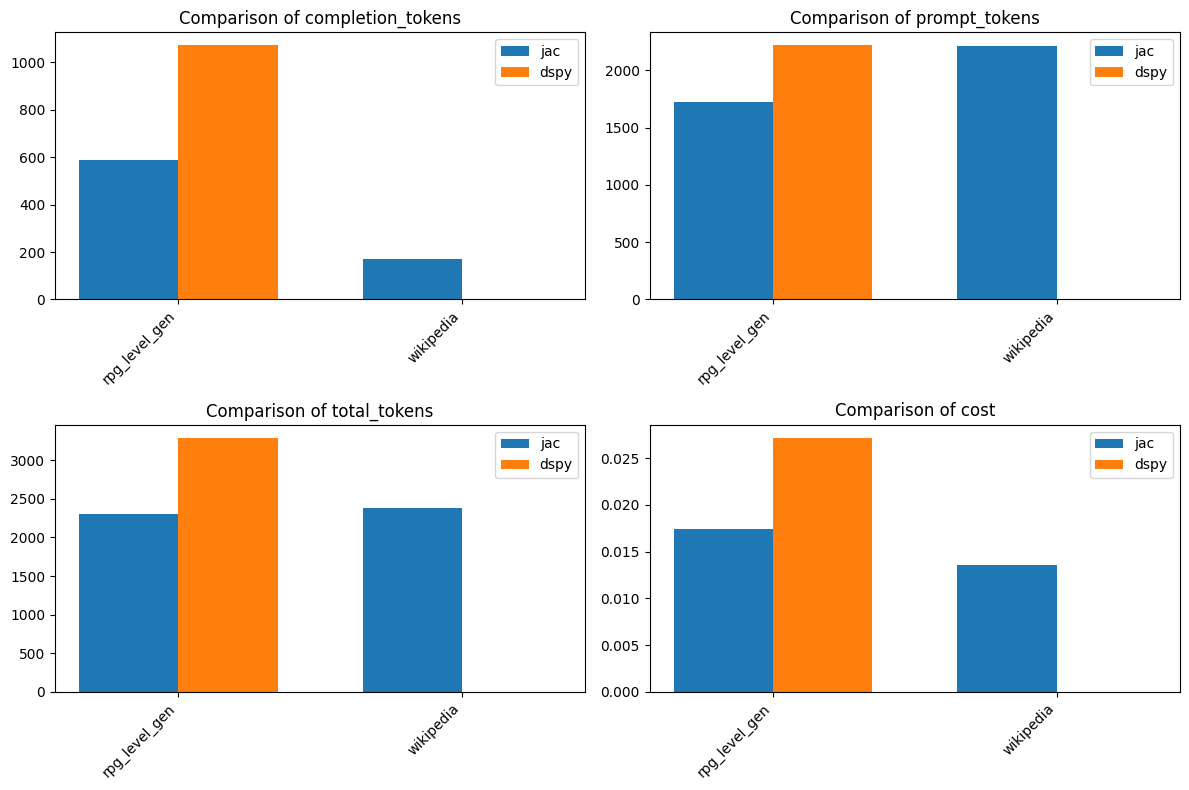

In [38]:
problems = results_df['problem'].unique()
criteria = ['completion_tokens', 'prompt_tokens', 'total_tokens', 'cost']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()

for i, criterion in enumerate(criteria):
    jac_data = results_df[f'jac_{criterion}']
    dspy_data = results_df[f'dspy_{criterion}']

    x = np.arange(len(problems))
    width = 0.35
    axs[i].bar(x - width/2, jac_data, width, label='jac')
    axs[i].bar(x + width/2, dspy_data, width, label='dspy')

    axs[i].set_xticks(x)
    axs[i].set_xticklabels(problems, rotation=45, ha='right')
    axs[i].set_title(f'Comparison of {criterion}')
    axs[i].legend()

plt.tight_layout()
plt.show()

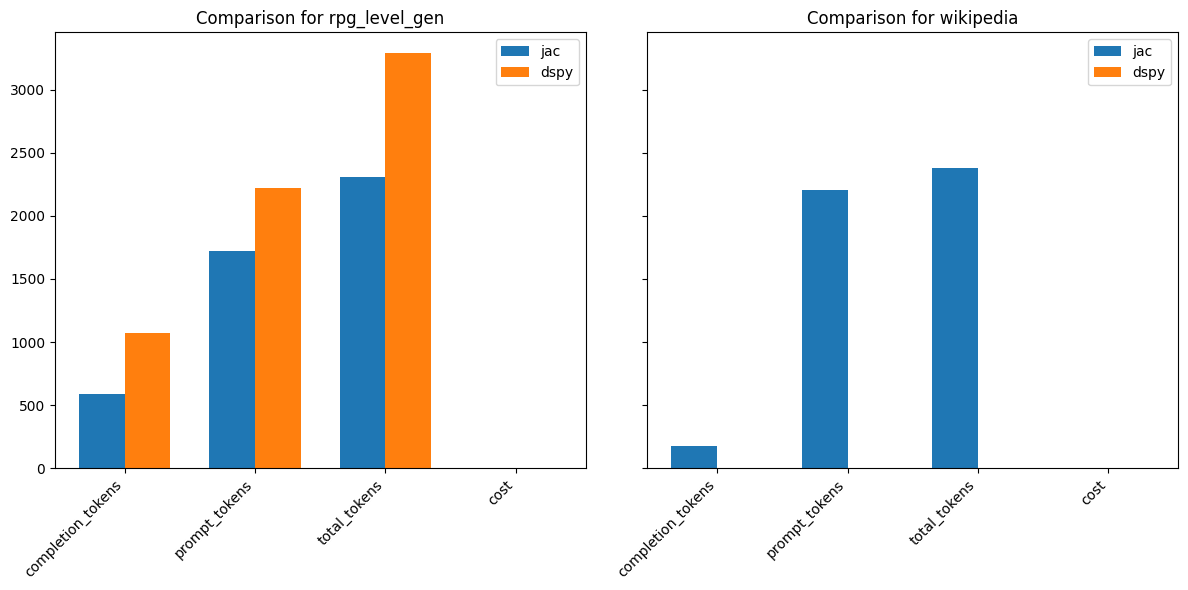

In [39]:
problems = results_df['problem'].unique()
criteria = ['completion_tokens', 'prompt_tokens', 'total_tokens', 'cost']

num_problems = len(problems)
num_cols = 2
num_rows = ceil(num_problems / num_cols)

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows), sharey=True)
axs = axs.flatten()

for i, problem in enumerate(problems):
    problem_data = results_df[results_df['problem'] == problem]

    x = np.arange(len(criteria))
    width = 0.35
    jac_data = [problem_data[f'jac_{criterion}'].values[0] for criterion in criteria]
    dspy_data = [problem_data[f'dspy_{criterion}'].values[0] for criterion in criteria]
    axs[i].bar(x - width/2, jac_data, width, label='jac')
    axs[i].bar(x + width/2, dspy_data, width, label='dspy')

    axs[i].set_xticks(x)
    axs[i].set_xticklabels(criteria, rotation=45, ha='right')
    axs[i].set_title(f'Comparison for {problem}')
    axs[i].legend()

for j in range(num_problems, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

@kugesan will add graphs

## Time Taken Analysis

In [44]:
import pstats

def get_time(problem, impl):
    try:
        p_dspy = pstats.Stats(f'results/{problem}/{impl}/profile.prof')
        total_time = p_dspy.total_tt
        llm_time = p_dspy.sort_stats('cumulative').stats[('/opt/conda/envs/mtllm-eval/lib/python3.12/site-packages/openai/_utils/_utils.py', 243, 'wrapper')][3]
        return total_time, llm_time
    except Exception:
        return 0,0

In [45]:
results_df_with_time = results_df.copy()
results_df_with_time['jac_total_time'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'jac')[0])
results_df_with_time['jac_llm_time'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'jac')[1])
results_df_with_time['dspy_total_time'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'dspy')[0])
results_df_with_time['dspy_llm_time'] = results_df_with_time['problem'].apply(lambda x: get_time(x, 'dspy')[1])
results_df_with_time["jac_runtime"] = results_df_with_time["jac_total_time"] - results_df_with_time["jac_llm_time"]
results_df_with_time["dspy_runtime"] = results_df_with_time["dspy_total_time"] - results_df_with_time["dspy_llm_time"]
results_df_with_time["jac_runtime_percent"] = results_df_with_time["jac_runtime"] / results_df_with_time["jac_total_time"]
results_df_with_time["dspy_runtime_percent"] = results_df_with_time["dspy_runtime"] / results_df_with_time["dspy_total_time"]

In [ ]:
results_df_with_time

,problem,jac_completion_tokens,jac_prompt_tokens,jac_total_tokens,dspy_completion_tokens,dspy_prompt_tokens,dspy_total_tokens,jac_cost,dspy_cost,jac_total_time,jac_llm_time,dspy_total_time,dspy_llm_time,jac_runtime,dspy_runtime,jac_runtime_percent,dspy_runtime_percent
0,mcq_reason,112,265,377,225,475,700,0.003005,0.005750,2.596898,2.538880,8.016374,5.397168,0.058017,2.619206,0.022341,0.326732
1,personality_finder,27,244,271,36,197,233,0.001625,0.001525,1.054815,0.994842,1.322209,1.296542,0.059974,0.025668,0.056857,0.019413
2,template,30,217,247,41,169,210,0.001535,0.001460,1.053593,1.002257,1.094972,1.064953,0.051336,0.030019,0.048725,0.027416
3,text_to_type,35,265,300,56,264,320,0.001850,0.002160,1.200889,1.111494,3.958992,2.579334,0.089395,1.379658,0.074440,0.348487


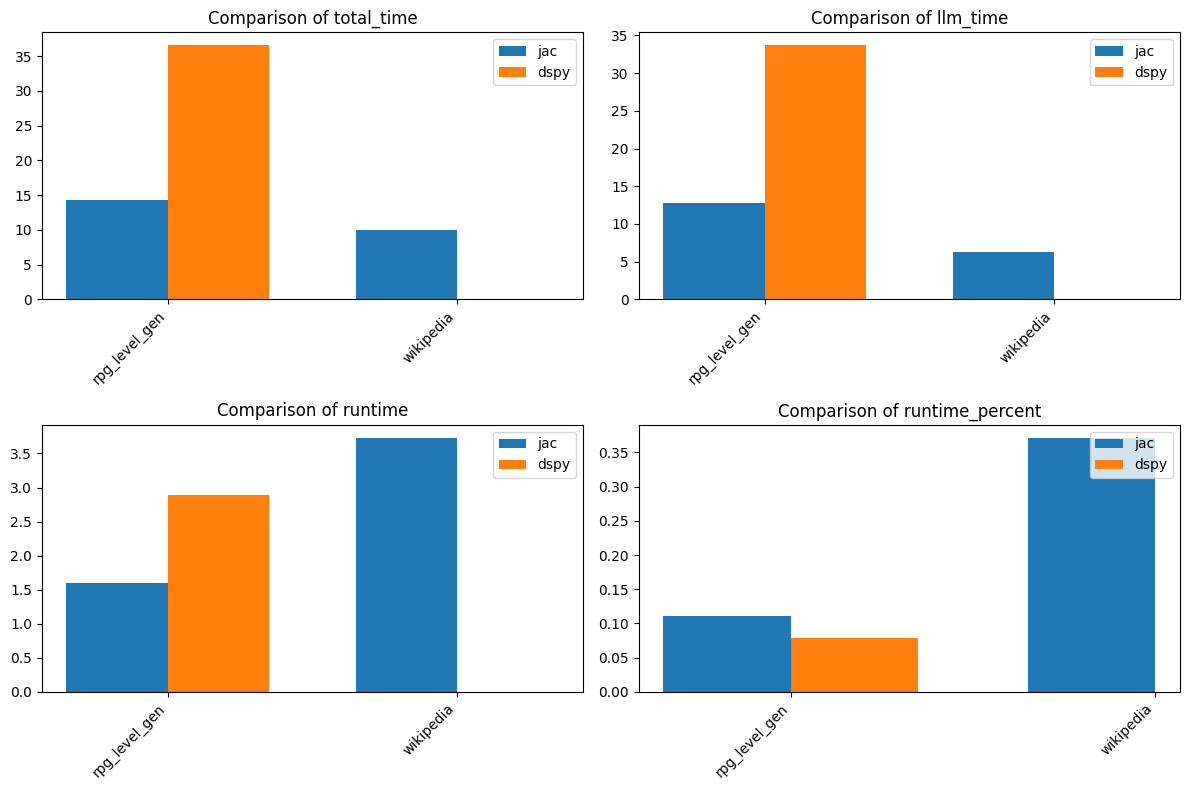

In [46]:
problems = results_df_with_time['problem'].unique()
criteria = ['total_time','llm_time','runtime','runtime_percent']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axs.flatten()

for i, criterion in enumerate(criteria):  # Truncate the criteria list
    jac_data = results_df_with_time[f'jac_{criterion}']
    dspy_data = results_df_with_time[f'dspy_{criterion}']

    x = np.arange(len(problems))
    width = 0.35
    axs[i].bar(x - width/2, jac_data, width, label='jac')
    axs[i].bar(x + width/2, dspy_data, width, label='dspy')

    axs[i].set_xticks(x)
    axs[i].set_xticklabels(problems, rotation=45, ha='right')
    axs[i].set_title(f'Comparison of {criterion}')
    axs[i].legend(loc='upper right')

plt.tight_layout()
plt.show()


KeyError: 'jac_runtime'

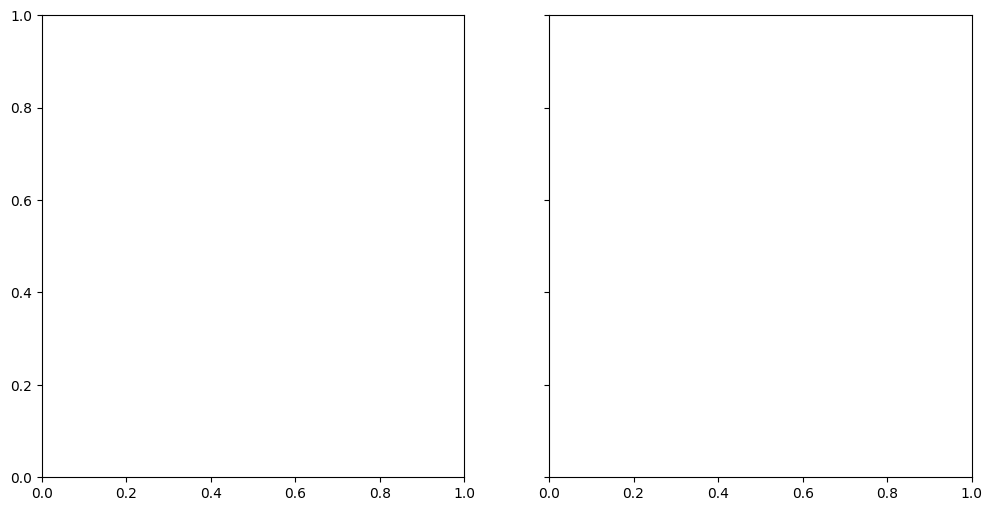

In [43]:

num_problems = len(problems)
num_cols = 2
num_rows = ceil(num_problems / num_cols)

fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6 * num_rows), sharey=True)
axs = axs.flatten()

for i, problem in enumerate(problems):
    problem_data = results_df_with_time[results_df['problem'] == problem]

    x = np.arange(len(criteria))
    width = 0.35
    
    jac_data = [problem_data[f'jac_{criterion}'].values[0] for criterion in criteria]
    dspy_data = [problem_data[f'dspy_{criterion}'].values[0] for criterion in criteria]
    
    axs[i].bar(x - width/2, jac_data, width, label='jac')
    axs[i].bar(x + width/2, dspy_data, width, label='dspy')

    axs[i].set_xticks(x)
    axs[i].set_xticklabels(criteria, rotation=45, ha='right')
    axs[i].set_title(f'Comparison for {problem}')
    axs[i].legend()

for j in range(num_problems, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
